In [55]:
import numpy as np

In [65]:
# first, define our problem size
n = 10
alpha = np.random.random((n, 1))
k = np.random.random((n, n))
sigma = np.array([[k[i][i]] for i in range(n)])

# TODO: figure out how to stitch together the r_opt values with the actual stock names
stock_names = [f'stock_{i}' for i in range(n)]

# TODO? figure out how to generate the confidence intervals of how much money you expect to make from this

# TODO, pick one stock to be the baseline (stock_0). Figure out some way of comparing
# stock_0's expected performance compared to our optimal solver

# Katrina's draft:

max_num_stocks = 5

# DRAFT END

# goal, generate some vector r such that:
# sum(r) = 1.0
# r represents our optimal investment portfolio


In [66]:
numbers = [1,2,3,4]
letters = ['a', 'b', 'c', 'd']

# zipping lists
print(list(zip(numbers, letters)))

# enumerating lists
print(list(enumerate(numbers)))

# for each syntax
print([(num, letter) for num, letter in zip(numbers, letters)])

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]
[(0, 1), (1, 2), (2, 3), (3, 4)]
[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]


In [67]:
# element-wise math

# square every term in alpha
alpha_element_squared = alpha * alpha
sigma_element_squared = sigma * sigma

# the 3.9 formula from
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
alpha / (alpha_element_squared + sigma_element_squared)


array([[1.01829317],
       [0.45976692],
       [0.84333024],
       [0.93741219],
       [0.7775781 ],
       [0.35667891],
       [3.24228532],
       [2.58641672],
       [0.32295928],
       [1.64056184]])

In [68]:
# invert matrices
k_inv = np.linalg.inv(k)

# formula 3.10 from 
# https://maslov.bioengineering.illinois.edu/optimal_investment_ijtaf.pdf
r_opt = np.dot(k_inv, alpha)


In [69]:
# hints that I'm not sure how they all go together

# from formula 3.11
# you know that if \lambda >= \alpha_i, then we can ignore that term

# Maybe if you sort all fo the \alpha_i terms, you can see if a solution for lambda exists where all of the smaller
# values are ignored, and all of the larger values are effected by \lambda

# if you look at each term in the sum of 3.12, they are piecewise linear wrt. \lambda


In [70]:
# idea one to solve this: use line search
# main idea: function 3.12 is monotically decreasing
# so if we pick upper/lower bounds of lambda, we can just do a line search and call it a day
# monotonically decreasing means the derivative of the function wrt lambda is <= 0 across all values of lambda

# upper bound, we know that if lambda causes all of the terms to be zero, we went too far.
# i.e., alpha_i - upper_bound_lambda <= 0 \forall i
upper_bound_lambda = np.max(alpha)

# lower bound, we know that each term in the sum is >= 0 and <= the total sum term.
# so just find the lower bound of each term and take the maximum out of all of these terms
# for each term, lambda = alpha_i - alpha_i^2 - sigma_i^2
# I know this because I can do high-school algebra in my head... work it out on paper if you can't
lower_bound_lambda = np.max(al
# # # TODO, think about cases where there are zero values in r_opt
# # r_opt_top_stocks = r_opt[np.argsort(-r_opt)[:max_num_stocks]]
# # r_opt_top_stocks /= np.sum(r_opt_top_stocks)

# r_opt_top_stocks = [r_opt_with_names[best_stock_index][0] for best_stock_index in best_stock_indices]
# r_opt_top_stocks = np.array(r_opt_top_stocks_with_names) / np.sum(r_opt_top_stocks_with_names)
# r_opt_top_stocks

# r_opt_top_stocks_with_names = [r_opt_with_names[best_stock_index] for best_stock_index in best_stock_indices]
# r_opt_top_stocks_with_namespha - alpha_element_squared - sigma_element_squared)

print(lower_bound_lambda, upper_bound_lambda)

# now line search/binary search... first we need to evaluate the value of the 3.12 summation expression
def eval_expression(lambda_value):
    # subtract one so I can get something like \sum - 1 = 0 to solve.
    fractional_terms = (alpha - lambda_value) / (alpha_element_squared + sigma_element_squared)
    # heavyside function
    fractional_terms = np.maximum(fractional_terms, 0)
    return np.sum(fractional_terms) - 1

# sanity check, the correct value (0) is between the upper bound and lower bound
eval_expression(lower_bound_lambda), eval_expression(upper_bound_lambda)

# there's a tolerance term usually, more on that later
tolerance = 1e-9

# initialize our loop with our initial guess
lower_lambda = lower_bound_lambda
upper_lambda = upper_bound_lambda
middle_lambda = (lower_bound_lambda + upper_bound_lambda) / 2

iterations = 0
while np.abs(eval_expression(middle_lambda)) > tolerance:
    middle_value = eval_expression(middle_lambda)
    if middle_value > 0:
        lower_lambda = middle_lambda
    else:
        upper_lambda = middle_lambda
    middle_lambda = (lower_lambda + upper_lambda) / 2

    iterations += 1
    print(f'iteration: {iterations}, {middle_lambda}, {eval_expression(middle_lambda)}')


SyntaxError: invalid syntax (<ipython-input-70-bebed1a3b150>, line 26)

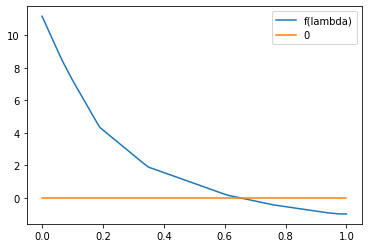

In [71]:
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 101)
plt.plot(x, [eval_expression(el) for el in x], label='f(lambda)')
plt.plot([0, 1], [0, 0], label='0')
plt.legend()

plt.show()


In [72]:
# get the optimal investment portfolio
r_opt = np.maximum(0, (alpha - middle_lambda) / (alpha_element_squared + sigma_element_squared))
r_opt = r_opt.flatten()

# r_opt_with_names = list(zip(r_opt, stock_names))
best_stock_indices = np.argsort(-r_opt)[:max_num_stocks]
best_stock_prices = r_opt[best_stock_indices]
best_stock_prices /= np.sum(best_stock_prices)

r_opt_top_stocks_with_names = []
for best_stock_price, best_stock_index in zip(best_stock_prices, best_stock_indices):
    r_opt_top_stocks_with_names.append([best_stock_price, stock_names[best_stock_index]])
r_opt_top_stocks_with_names

[[0.33864434950542427, 'stock_0'],
 [0.25825517403279313, 'stock_2'],
 [0.2537399209638218, 'stock_4'],
 [0.1493605554979608, 'stock_3'],
 [0.0, 'stock_1']]

In [73]:
# brief lecture on probabilities (mean/variance)
# E[X]=mean(X), Var[X]=Variance(X)
# let a be a constant
# Var[X] = E[X^2] - E[X]^2
# aE[X] = E[aX]
# a^2Var[X] = Var[(aX)]
# Let v be some vector, K be the covariance matrix
# Var(Kv) = v^t K v

# we now have r_opt, find the mean and variance of investing in r_opt
alpha, sigma



(array([[0.97974902],
        [0.3365742 ],
        [0.93847923],
        [0.7598858 ],
        [0.96964304],
        [0.06495819],
        [0.18906465],
        [0.34945972],
        [0.09914317],
        [0.60817662]]),
 array([[0.04733004],
        [0.78662049],
        [0.48174894],
        [0.48290201],
        [0.55389207],
        [0.42178188],
        [0.15022222],
        [0.11397969],
        [0.54511846],
        [0.02887218]]))

In [74]:
r_opt_top_stocks

array([0.37023093, 0.29365479, 0.14020839, 0.11830588, 0.07760001])

In [31]:
np.sum(r_opt_top_stocks)

1.0

In [28]:
sum([el[0] for el in r_opt_top_stocks_with_names])

0.9371989780382527

In [29]:
r_opt_top_stocks_with_names

[(0.34698005377482793, 'stock_3'),
 (0.27521296570724463, 'stock_8'),
 (0.13140315653853846, 'stock_7'),
 (0.11087614849820097, 'stock_5'),
 (0.07272665351944062, 'stock_1')]

In [30]:
x = 2
x /= 2
print(x)

1.0


In [21]:
numbers = [1,2,3,4]
letters = ['a', 'b', 'c', 'd']

# zipping lists
print(list(zip(numbers, letters)))

# enumerating lists
print(list(enumerate(numbers)))

# for each syntax
print([(num, letter) for num, letter in zip(numbers, letters)])

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]
[(0, 1), (1, 2), (2, 3), (3, 4)]
[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]


In [24]:
np.argsort(-r_opt)[:max_num_stocks]

array([3, 8, 7, 5, 1])

In [23]:
# how would we print the amount we should invest in each stock by name?

# what variables should you look at to compute this?
# r_opt, stock_names

# what should the output look like?
# [[stock_0, investment_percent_0], [stock_1, investment_percent_1], etc...]

# how do we get there?
list(zip(r_opt, stock_names))


[(0.0, 'stock_0'),
 (0.07272665351944062, 'stock_1'),
 (0.06280102276540575, 'stock_2'),
 (0.34698005377482793, 'stock_3'),
 (0.0, 'stock_4'),
 (0.11087614849820097, 'stock_5'),
 (0.0, 'stock_6'),
 (0.13140315653853846, 'stock_7'),
 (0.27521296570724463, 'stock_8'),
 (0.0, 'stock_9')]

In [19]:
r_opt.shape[0] == n, len(stock_names)

(True, 10)

In [34]:
r_opt_top_stocks

array([0.32617414, 0.22693462, 0.17060951, 0.14838623, 0.1278955 ])

In [26]:
# sorts things by index
np.argsort(-r_opt.flatten())

array([7, 3, 0, 8, 5, 2, 4, 1, 6, 9])

In [24]:
r_opt

array([[0.15357192],
       [0.        ],
       [0.08564533],
       [0.20427223],
       [0.01421777],
       [0.11512346],
       [0.        ],
       [0.29360138],
       [0.13356792],
       [0.        ]])

In [28]:
r_opt[7], np.max(r_opt)

(array([0.29360138]), 0.29360138030151584)